# Códigos Examen de Algoritmos Bioinspirados 
Chiara Bombardieri Balanzá - A01659462
 

In [12]:
import numpy as np
import math
from dataclasses import dataclass
from typing import List, Tuple, Optional
from __future__ import annotations
import matplotlib.pyplot as plt

# Código Problema del Viajante para 10 ciudades

In [13]:
# Función de distancias euclidianas:
def distancia_euclidiana(coords):
    """
    Calcula la matriz de distancias euclidianas (longitud de la línea recta entre dos puntos en un espacio normal) 
    entre TODAS las ciudades.

    - coords: arreglo NumPy de shape (N, 2) con coordenadas (x, y) de N ciudades.
    Devuelve:
    - Matriz (N, N) D tal que D[i, j] = distancia entre ciudad i y j.
    """
    diff = coords[:, None, :] - coords[None, :, :]  
    D = np.sqrt((diff**2).sum(axis=2))              
    return D

#Función de longitud del recorrido 
def longitud_tour(tour, D):
    """
    Calcula la longitud total de un ciclo cerrado, el cual es típico en el problema del viajante.
- Tour: Una permutación de ciudades en el orden en el que se visitan
- D: Matriz NxN con las distancias entre ciudades
    """
    n = len(tour) # Número de ciudades en el tour 
    """
    sum(D[tour[i], tour[(i + 1) % n]] for i in range(n)) 
    recorre cada pocisión (i) del tour, toma la ciudad actual y la siguiente ciudad y cierra el ciclo, 
    haciendo que cuando (i) es la última posición, la "siguiente" sea la primera. 

    Se devuelve la longitud de todo el ciclo cerrado.
    """
    return sum(D[tour[i], tour[(i + 1) % n]] for i in range(n)) 


# Función que verifica si los recorridos tienene una permutación válida. 
def es_perm_valida(tour, n):
    """
    Hace una verificación de que "tour" es una permutación válida de n'1.
    - len(tour) == n -> Exige que haya exactamente (n) elementos.
    - set(tour) == set(range(n)) -> Covierte "tour" en un conjunto. Esto asegura que están 
    todos los índices válidos, cada uno una sola vez y no hay valores fuera del rango. 
    """
    return len(tour) == n and set(tour) == set(range(n))

OPERDADORES DEL ALGORITMO GENÉTICO 

In [14]:
# Función del torneo de selección
def torneo_seleccion(poblacion, costos, k, rng):
    """
    Selección por torneo (MINIMIZACIÓN del costo):
    - Elige k índices aleatorios sin reemplazo.
    - Gana el individuo con menor costo entre esos k.
    - Se devuelve UNA COPIA del ganador (para no tocar el original).
    """
    idxs = rng.choice(len(poblacion), size=k, replace=False)  # candidatos
    mejor = min(idxs, key=lambda i: costos[i])                # índice con menor costo
    return poblacion[mejor][:]                                # copia del ganador

#Función de Cruce 
def cruce_OX(p1, p2, rng):
    """
    Se construye un hijo que respeta un bloque del padre 1 y el orden relativo del padre 2 en el resto, 
    sin repetir ciudades.
    """
    n = len(p1)
    c1, c2 = sorted(rng.choice(n, size=2, replace=False))  # Elige dos posiciones distintas y las ordena
    hijo = [-1] * n                                        # -1 = hueco
    
    # Copia blque de P1
    hijo[c1:c2] = p1[c1:c2]                                # Fija un segmento del padre 1 (siempre enlas mismas posiciones)
    usados = set(hijo[c1:c2])                              # genes ya colocados

    # Se rellena desde C2
    """
    A continuación se recorre el padre 2 circularmente empezando en C2, de esta forma se preserva el 
    orden relativo de sus genes y se evitan duplicados, así el hijo queda como una permutación válida. 
    Además de que se lleva acabo un chequeo de seguridad el cual lanza un error si algo sale mal.
    """
    pos = c2                                              
    for k in range(n):                                   
        gene = p2[(c2 + k) % n]                           
        if gene not in usados:
            hijo[pos % n] = gene
            pos += 1
            
    assert es_perm_valida(hijo, n), "Cruce OX produjo permutación inválida."
    return hijo

#Función de mutación por inversión 
def mutacion_inversion(ind, p_mut, rng):
    """
    Con cierta probabilidad toma un subtrayecto del individuo y lo revierte.
    - Se aplica mutación con probabilidad "p_mut"
    - Se eligen dos posiciones distintas del vector "ind" y se ordenan.
    - Se toma el slice del individuo, el cual se encuentra entre i y j y este se revierte.
    Este proceso mantiene una permutación válida, ya quesolo se reordena y no se crean duplicados. 
    """
    if rng.random() < p_mut:
        n = len(ind)
        i, j = sorted(rng.choice(n, size=2, replace=False))
        ind[i:j] = ind[i:j][::-1]  # invertir el subtrayecto
    return ind

Bucle Principal

In [15]:
# Función que evalua a la población 
def evaluar_poblacion(poblacion, D):
    """
    Hace la evaluación de toda la población midiendo el costo (en este caso la longitud del recorrido) 
    de cada individuo y devuelve la lista de costos y el índice del mejor (el que tiene menor costo). 
    """
    costos = [longitud_tour(ind, D) for ind in poblacion]
    best_idx = int(np.argmin(costos))
    return costos, best_idx

#Ejecución del AG para el problema de viajante inciso 
def ga_tsp(coords,
           pop_size=150,
           generaciones=600,
           k_torneo=3,
           p_cruce=0.9,
           p_mut=0.2,
           elite=2,
           seed=42,
           verbose=True,
           verbose_every=50):
    """
    Parámetros:
      - coords: array (N, 2) con coordenadas de al menos 10 ciudades.
      - pop_size: tamaño de población (más grande = más diversidad, más costo).
      - generaciones: iteraciones del GA.
      - k_torneo: tamaño del torneo (más grande = mayor presión selectiva).
      - p_cruce: probabilidad de aplicar cruce OX a una pareja de padres.
      - p_mut: probabilidad de mutación por inversión para CADA hijo.
      - elite: cuántos mejores se copian tal cual a la siguiente generación.
      - seed: semilla para reproducibilidad.
      - verbose: imprimir progreso.
      - verbose_every: cada cuántas generaciones imprimir.

    Devuelve:
      - mejor_tour: mejor permutación encontrada
      - mejor_costo: longitud de dicho tour
      - historial: lista del mejor costo acumulado por generación (para graficar)
    """
    # Generador de aleatoriedad reproducible
    rng = np.random.default_rng(seed)

    # Número de ciudades y matriz de distancias
    N = coords.shape[0]
    assert N >= 10, "Para el examen: utiliza al menos 10 ciudades."
    D = distancia_euclidiana(coords)

    # Inicialización: población de permutaciones aleatorias
    poblacion = [rng.permutation(N).tolist() for _ in range(pop_size)]

    # Evaluación inicial
    costos, best_idx = evaluar_poblacion(poblacion, D)
    mejor_tour = poblacion[best_idx][:]
    mejor_costo = costos[best_idx]
    historial = [mejor_costo]

    if verbose:
        print(f"[Gen 0] Mejor costo: {mejor_costo:.4f}")

    # Evolución por generaciones
    for g in range(1, generaciones + 1):
        # copiamos los 'elite' mejores directamente
        orden = np.argsort(costos)                 # índices ordenados por costo (menor a mayor)
        nueva_pob = [poblacion[i][:] for i in orden[:elite]]  # copias de los mejores

        # REPRODUCCIÓN: rellenar hasta pop_size
        while len(nueva_pob) < pop_size:
            # Selección de padres vía TORNEO
            p1 = torneo_seleccion(poblacion, costos, k_torneo, rng)
            p2 = torneo_seleccion(poblacion, costos, k_torneo, rng)

            # CRUCE OX con probabilidad p_cruce; si no, clonamos
            if rng.random() < p_cruce:
                h1 = cruce_OX(p1, p2, rng)
                h2 = cruce_OX(p2, p1, rng)
            else:
                h1, h2 = p1[:], p2[:]

            # MUTACIÓN por inversión para cada hijo
            h1 = mutacion_inversion(h1, p_mut, rng)
            h2 = mutacion_inversion(h2, p_mut, rng)

            # Añadimos a nueva población (cuidando no pasarnos de pop_size)
            nueva_pob.append(h1)
            if len(nueva_pob) < pop_size:
                nueva_pob.append(h2)

        # REEMPLAZO: la nueva población sustituye a la anterior
        poblacion = nueva_pob

        # EVALUACIÓN: medir costos y actualizar mejor global
        costos, gen_best_idx = evaluar_poblacion(poblacion, D)
        gen_best_cost = costos[gen_best_idx]
        if gen_best_cost < mejor_costo:
            mejor_costo = gen_best_cost
            mejor_tour = poblacion[gen_best_idx][:]

        # Guardar historia del mejor costo (para trazar convergencia)
        historial.append(mejor_costo)

        # Log cada cierto número de generaciones
        if verbose and (g % verbose_every == 0 or g == generaciones):
            print(f"[Gen {g}] Mejor costo: {mejor_costo:.4f}")

    # Resultado final
    return mejor_tour, mejor_costo, historial

Ejecución para inciso (A) Bloque 2:

[Gen 0] Mejor costo: 356.1556
[Gen 50] Mejor costo: 283.3272
[Gen 100] Mejor costo: 283.3272
[Gen 150] Mejor costo: 283.3272
[Gen 200] Mejor costo: 283.3272
[Gen 250] Mejor costo: 283.3272
[Gen 300] Mejor costo: 283.3272
[Gen 350] Mejor costo: 283.3272
[Gen 400] Mejor costo: 283.3272
[Gen 450] Mejor costo: 283.3272
[Gen 500] Mejor costo: 283.3272
[Gen 550] Mejor costo: 283.3272
[Gen 600] Mejor costo: 283.3272
-----------------------------------------------
                    RESULTADOS                 
-----------------------------------------------

Mejor costo encontrado: 283.3272
Mejor tour (ciclo): [0, 5, 3, 4, 9, 8, 2, 7, 6, 1] -> 0


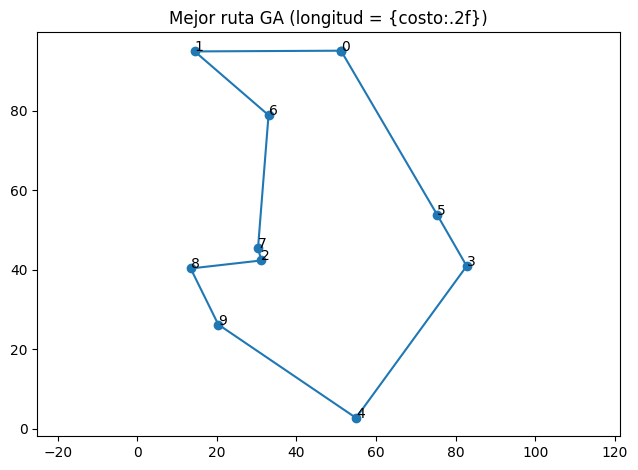

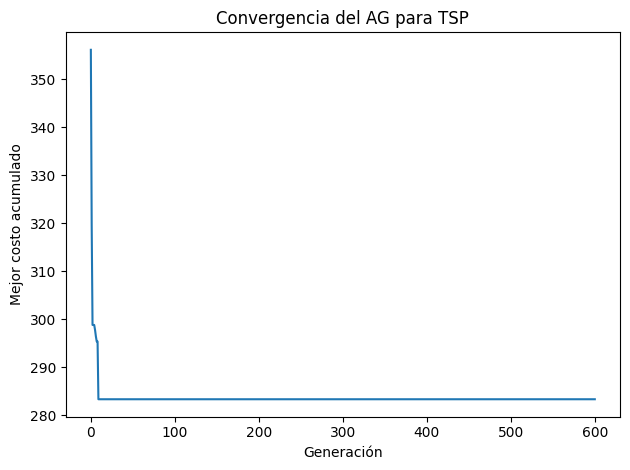

In [18]:
rng_demo = np.random.default_rng(1)      # semilla para reproducibilidad
N_CIUDADES = 10 #Utilizamos el mínimo de ciudades posibles 
coords = rng_demo.uniform(0, 100, size=(N_CIUDADES, 2))


tour, costo, hist = ga_tsp(coords,
           pop_size=150,
           generaciones=600,
           k_torneo=3,
           p_cruce=0.9,
           p_mut=0.2,
           elite=2,
           seed=42,
           verbose=True,
           verbose_every=50)

#Reordenar tour para que empiece en la ciudad 0 si está presente
if 0 in tour:
    i0 = tour.index(0)
    tour = tour[i0:] + tour[:i0]

# RESULTADOS 
print("-----------------------------------------------")
print("                    RESULTADOS                 ")
print("-----------------------------------------------")
print("")
print("Mejor costo encontrado:", round(costo, 4))
print("Mejor tour (ciclo):", tour, "->", tour[0])

# Gráficos 
ruta = np.array([coords[i] for i in tour] + [coords[tour[0]]])  # cerrar ciclo
plt.figure()
plt.plot(ruta[:, 0], ruta[:, 1], "-o")                          # líneas y nodos
for i, (x, y) in enumerate(coords):                             # etiquetas de ciudades
    plt.text(x, y, str(i))
plt.title("Mejor ruta GA (longitud = {costo:.2f})")
plt.axis("equal")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(hist)
plt.xlabel("Generación")
plt.ylabel("Mejor costo acumulado")
plt.title("Convergencia del AG para TSP")
plt.tight_layout()
plt.show()


# Código Problema del Viajante para 100 ciudades

In [ ]:
rng_demo = np.random.default_rng(1)      # semilla para reproducibilidad
N_CIUDADES = 100
coords = rng_demo.uniform(0, 100, size=(N_CIUDADES, 2))


tour, costo, hist = ga_tsp(coords,
           pop_size=150,
           generaciones=600,
           k_torneo=3,
           p_cruce=0.9,
           p_mut=0.2,
           elite=2,
           seed=42,
           verbose=True,
           verbose_every=50)

#Reordenar tour para que empiece en la ciudad 0 si está presente
if 0 in tour:
    i0 = tour.index(0)
    tour = tour[i0:] + tour[:i0]

# RESULTADOS 
print("-----------------------------------------------")
print("                    RESULTADOS                 ")
print("-----------------------------------------------")
print("")
print("Mejor costo encontrado:", round(costo, 4))
print("Mejor tour (ciclo):", tour, "->", tour[0])

# Gráficos 
ruta = np.array([coords[i] for i in tour] + [coords[tour[0]]])  # cerrar ciclo
plt.figure()
plt.plot(ruta[:, 0], ruta[:, 1], "-o")                          # líneas y nodos
for i, (x, y) in enumerate(coords):                             # etiquetas de ciudades
    plt.text(x, y, str(i))
plt.title("Mejor ruta GA (longitud = {costo:.2f})")
plt.axis("equal")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(hist)
plt.xlabel("Generación")
plt.ylabel("Mejor costo acumulado")
plt.title("Convergencia del AG para TSP")
plt.tight_layout()
plt.show()
